# Car Vs Ambulance classification using ensemble CNN


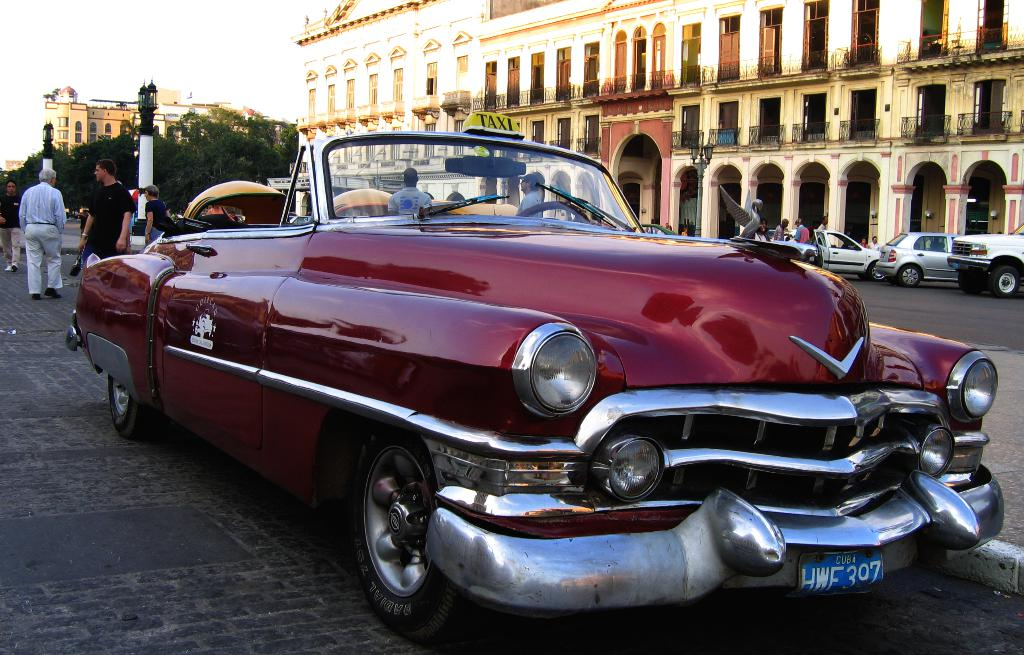

## 1. **Introduction**
Here’s a bullet-point description of the dataset:

### About Dataset
**Source of the Dataset** : [image-classification-and-yolo-dataset](https://www.kaggle.com/datasets/amansingh0000000/image-classification-and-yolo-dataset/data) \
**Classes**: Contains images of two primary classes: cars and ambulances. \
**Diversity**: Images include various angles, lighting conditions, and backgrounds.  \
**Labeling**: Each image is labeled for accurate classification and detection. \

**Applications**: \
**Image classification**: Identifying whether an image contains a car or an ambulance. \
**Object detection**: Locating and recognizing cars and ambulances within images. \
**Use Cases**: Ideal for projects such as traffic monitoring, emergency vehicle detection, and automated vehicle recognition systems. \
               Train file is for different types of Cars and Ambulances images. \
               Label file for the labels,which show the labels regarding about the images. 


## Planning
* Dataset also contain coordinates for each object in the image
* First I will try to work on only Object classification problem
* Then i will try to use those coordinates and make this problem as an Object detection

## 2. Data Preparation

In [61]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import opendatasets as od
import random
import pathlib 
import os

In [62]:
def download_datasets_from_kaggle(dataset_url:str, dataset_dir:str)-> None:
    # Dowload the dataset
    data_dir = pathlib.Path(dataset_dir)
    data_dir.mkdir(exist_ok=True)
    if os.path.isdir(dataset_dir):
        od.download(dataset_url, data_dir=data_dir)
    

In [63]:
# Dowload the dataset


dataset_url = 'https://www.kaggle.com/datasets/amansingh0000000/image-classification-and-yolo-dataset/data'
# Look into the data directory
dataset_dir = '../dataset'
download_datasets_from_kaggle(dataset_url=dataset_url, dataset_dir=dataset_dir)

Skipping, found downloaded files in "../dataset/image-classification-and-yolo-dataset" (use force=True to force download)


I. Quick look at the downloaded data

In [64]:
dataset_dir= dataset_dir + '/image-classification-and-yolo-dataset' + '/Ambulance_Car'
dataset_dir

'../dataset/image-classification-and-yolo-dataset/Ambulance_Car'

In [65]:
train_dir = dataset_dir + '/Train'
lables_dir = dataset_dir + '/Label'

In [66]:
len(os.listdir(train_dir)), len(os.listdir(lables_dir))

(1138, 1138)

In [67]:
# images_per_class = []
# all_classes = []
# for class_name in classes:
#     total_images = len(os.listdir(os.path.join(dataset_dir, class_name)))
#     images_per_class.append(total_images)
#     all_classes.append(class_name)
#     print(f'{class_name.capitalize()}: contains {total_images} images')

II. Load data into the memory

In [68]:
import glob
import cv2

images = []
labels = []

for _image_path in glob.glob(train_dir+"/*.jpg"):
    _img = cv2.imread(filename=_image_path)
    _img = cv2.resize(_img, (224,224))
    # print(_image_path)
    file_name_without_ext = _image_path.split('/')[-1].split('.')[0]
    label_file = f'{lables_dir}/{file_name_without_ext}.txt'
    # print(label_file)
    with open(label_file, 'r') as _labels:
        for line in _labels.readlines():
            _label, x_min, y_min, x_max, y_max = line.split()
            labels.append(_label)
            images.append(_img)
            # print(_label)
              

In [69]:
len(images), len(labels)

(2784, 2784)

In [70]:
def plot_images_with_label(images, labels):
    random_nums = random.sample(range(0, len(images)), 6)
    for idx, rand_num in enumerate(random_nums):
        img_resize = cv2.resize(images[rand_num], (224,224))
        plt.subplot(3, 3, idx+1)
        plt.imshow(img_resize)
        plt.title(labels[rand_num])
        plt.axis('off')
    plt.show() 

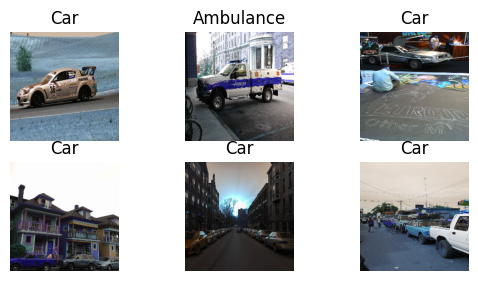

In [71]:
plot_images_with_label(images, labels)

### Data transforms (normalization & data augmentation)

Dataset split for training and testing

In [72]:
import numpy as np
images_arr = np.array(images)
labels_arr = np.array(labels)
images_arr.shape, labels_arr.shape

((2784, 224, 224, 3), (2784,))

In [73]:
images_arr[0]

array([[[ 84,  99,  98],
        [ 83,  95,  99],
        [ 87, 106, 103],
        ...,
        [ 55,  43,  33],
        [ 50,  37,  29],
        [ 48,  35,  27]],

       [[ 81, 102, 107],
        [ 93, 104, 113],
        [ 87,  99,  99],
        ...,
        [ 50,  38,  29],
        [ 49,  36,  28],
        [ 50,  37,  29]],

       [[ 88, 100, 100],
        [ 92, 106, 108],
        [ 90,  97, 100],
        ...,
        [ 50,  38,  32],
        [ 56,  40,  33],
        [ 54,  39,  33]],

       ...,

       [[ 38,  37,  33],
        [ 21,  20,  16],
        [  5,   5,   5],
        ...,
        [ 42,  40,  37],
        [ 46,  45,  41],
        [ 40,  40,  35]],

       [[  2,   1,   1],
        [ 15,  17,  14],
        [  9,   7,   7],
        ...,
        [ 40,  39,  36],
        [ 43,  43,  39],
        [ 42,  42,  36]],

       [[ 55,  49,  43],
        [ 30,  29,  28],
        [ 12,  12,  12],
        ...,
        [ 43,  43,  37],
        [ 39,  37,  36],
        [ 44,  44,  38]]

In [74]:
# Normalizing images
images_arr = images_arr/255.
images_arr[0]

array([[[0.32941176, 0.38823529, 0.38431373],
        [0.3254902 , 0.37254902, 0.38823529],
        [0.34117647, 0.41568627, 0.40392157],
        ...,
        [0.21568627, 0.16862745, 0.12941176],
        [0.19607843, 0.14509804, 0.11372549],
        [0.18823529, 0.1372549 , 0.10588235]],

       [[0.31764706, 0.4       , 0.41960784],
        [0.36470588, 0.40784314, 0.44313725],
        [0.34117647, 0.38823529, 0.38823529],
        ...,
        [0.19607843, 0.14901961, 0.11372549],
        [0.19215686, 0.14117647, 0.10980392],
        [0.19607843, 0.14509804, 0.11372549]],

       [[0.34509804, 0.39215686, 0.39215686],
        [0.36078431, 0.41568627, 0.42352941],
        [0.35294118, 0.38039216, 0.39215686],
        ...,
        [0.19607843, 0.14901961, 0.1254902 ],
        [0.21960784, 0.15686275, 0.12941176],
        [0.21176471, 0.15294118, 0.12941176]],

       ...,

       [[0.14901961, 0.14509804, 0.12941176],
        [0.08235294, 0.07843137, 0.0627451 ],
        [0.01960784, 0

In [75]:
labels_arr[:5]

array(['Car', 'Car', 'Car', 'Car', 'Car'], dtype='<U9')

In [81]:

label_names = ['car', 'ambulance']

In [82]:
from sklearn.calibration import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_arr)
encoded_labels[:5], label_encoder.classes_

(array([1, 1, 1, 1, 1]), array(['Ambulance', 'Car'], dtype='<U9'))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(images_arr, labels_arr, test_size=0.2, shuffle=True, random_state=42) 
len(X_train), len(X_test)

(2227, 557)

In [78]:
#  Convert the split data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


2024-09-18 18:27:14.882748: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2681806848 exceeds 10% of free system memory.
2024-09-18 18:27:19.958330: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2681806848 exceeds 10% of free system memory.


In [79]:
BATCH_SIZE=32
# Batch the dataset and Prefetch to optimize performance
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model 1 

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself

        inputShape = (height, width, depth)
        chanDim = -1
        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        return Sequential([
            # first CONV => RELU => CONV => RELU => POOL layer set
            Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=inputShape),
            BatchNormalization(axis=chanDim),

            Conv2D(32, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # second CONV => RELU => CONV => RELU => POOL layer set
            Conv2D(64, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            Conv2D(64, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # first (and only) set of FC => RELU layers
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),

            # softmax classifier
            Dense(classes, activation='softmax')

        ])

In [87]:
opt = SGD(learning_rate=1e-2, weight_decay=0.01 / 40, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=224, height=224, depth=3, classes=1)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(train_dataset,
              validation_data=test_dataset,
              batch_size=64,
              epochs=40,
              verbose=1)

[INFO] training network...
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
I0000 00:00:1726684373.914092    4603 service.cc:146] XLA service 0x7ad468003180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726684373.914287    4603 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-09-18 18:32:53.948354: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at xla_ops.cc:577 : INVALID_ARGUMENT: Detected unsupported operations when trying to compile graph __inference_one_step_on_data_3936[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data_1}}
	 (OpKernel was found, but attributes di

InvalidArgumentError: Graph execution error:

Detected at node data_1 defined at (most recent call last):
<stack traces unavailable>
Detected at node data_1 defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_3936[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data_1}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[32]], _user_specified_name="data", index=1){{node data_1}}
The op is created at: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>
File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start
File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start
File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever
File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code
File "/tmp/ipykernel_676/3459989129.py", line 7, in <module>
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/usr/local/lib/python3.11/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "/usr/local/lib/python3.11/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "/usr/local/lib/python3.11/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
	tf2xla conversion failed while converting __inference_one_step_on_data_3936[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_4067]